# INTRODUCTION

## Libraries

In [126]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.compose import ColumnTransformer


import tensorflow as tf
from tensorflow.data import Dataset, AUTOTUNE

from keras import layers, models, Sequential, regularizers
from keras.layers import SimpleRNN, Dense, Dropout, Embedding, LSTM, GRU
from keras.optimizers.legacy import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils import timeseries_dataset_from_array
from keras.utils import plot_model
from keras.regularizers import L1, L2, L1L2

import keras_tuner as kt

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Import data & column groups

In [2]:
DAILY_DATA_PATH = "data.v3/daily" 

df = pd.read_parquet(os.path.join(DAILY_DATA_PATH, "daily_flights_and_weather_merged.parquet"))

# Flights column groups
flights_terminal_cols = ['flights_arr_A', 'flights_arr_B', 'flights_arr_C', 'flights_arr_D', 'flights_arr_E',
                         'flights_dep_A', 'flights_dep_B', 'flights_dep_C', 'flights_dep_D', 'flights_dep_E']

flights_non_terminal_cols = ['flights_total', 'flights_cancel', 'flights_delay', 'flights_ontime',
                             'flights_arr_ontime', 'flights_arr_delay', 'flights_arr_cancel',
                             'flights_dep_ontime', 'flights_dep_delay', 'flights_dep_cancel']

flights_percentage_cols = ['flights_cancel_pct', 'flights_delay_pct', 'flights_ontime_pct',
                            'flights_arr_delay_pct', 'flights_arr_ontime_pct', 'flights_arr_cancel_pct',
                            'flights_dep_delay_pct', 'flights_dep_ontime_pct', 'flights_dep_cancel_pct']

# Date column groups
date_cols = ['date', 'covid', 'ordinal_date', 'year', 'month', 'day_of_month', 'day_of_week', 'season', 'holiday', 'halloween', 'xmas_eve', 'new_years_eve', 'jan_2', 'jan_3', 'day_before_easter', 'days_until_xmas', 'days_until_thanksgiving', 'days_until_july_4th', 'days_until_labor_day', 'days_until_memorial_day']

# Weather column groups
weather_cols = ['wx_temperature_max', 'wx_temperature_min', 'wx_apcp', 'wx_prate', 'wx_asnow', 'wx_frozr', 'wx_vis', 'wx_gust', 'wx_maxref', 'wx_cape', 'wx_lftx', 'wx_wind_speed', 'wx_wind_direction']

# Lag column groups
lag_cols =  ['flights_total_lag_1', 'flights_total_lag_2', 'flights_total_lag_3', 'flights_total_lag_4', 'flights_total_lag_5', 'flights_total_lag_6', 'flights_total_lag_7', 'flights_cancel_lag_1', 'flights_cancel_lag_2', 'flights_cancel_lag_3', 'flights_cancel_lag_4', 'flights_cancel_lag_5', 'flights_cancel_lag_6', 'flights_cancel_lag_7']

## Train Test Split - "flights_ontime"

In [3]:
# Select features and targets
train_features = ['random'] + date_cols + weather_cols + lag_cols
targets = flights_non_terminal_cols + flights_percentage_cols

# Create X and y
X = df[train_features].drop('date', axis=1)
y = df[targets]

# Split data into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y['flights_ontime'], test_size=0.1, random_state=42)

# Split data into X_train_rull and y_train_full into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)

# Print shapes
print("X_train_full shape:", X_train_full.shape)
print("y_train_full shape:", y_train_full.shape)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("X_Test shape:", X_test.shape)
print("y_Test shape:", y_test.shape)

X_train_full shape: (1516, 47)
y_train_full shape: (1516,)
X_train shape: (1364, 47)
y_train shape: (1364,)
X_Test shape: (169, 47)
y_Test shape: (169,)


# PREPROCESS FOR DENSE NETWORK

In [4]:
print(f"Feature names: {X.columns.tolist()}")
print(f"Target columns: {y.columns.tolist()}", end="\n\n")
print("Unique data types in X", X.dtypes.value_counts(), sep = '\n')

# Identify categorical and numeric columns in X
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X.select_dtypes(include = ['float64', 'float32', 'int32', 'int64']).columns.tolist()

print(f"\nCategorical columns to one-hot-encode: {categorical_cols}")

# Fit transformers to the training data
f_scaler = StandardScaler()
f_scaler.fit(X_train[numeric_cols])

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # Some observed holidays may not be in the training data
ohe.fit(X_train[categorical_cols])

t_scaler = StandardScaler()
t_scaler.fit(y_train.values.reshape(-1, 1)) # reshape y_train to be 2D

# Define preprocessor
def preprocess(features, target, set_global_scaler = False):
    global global_targer_scaler

    scaled_features = f_scaler.transform(features[numeric_cols])
    encoded_features = ohe.transform(features[categorical_cols])
    scaled_target = t_scaler.transform(target.values.reshape(-1, 1))
    processed_features = np.concatenate([scaled_features, encoded_features], axis=1)

    if set_global_scaler:
        global_targer_scaler = t_scaler

    return processed_features, scaled_target

# Preprocess the data
X_train_d, y_train_d = preprocess(X_train, y_train, set_global_scaler=True)
X_val_d, y_val_d = preprocess(X_val, y_val)

Feature names: ['random', 'covid', 'ordinal_date', 'year', 'month', 'day_of_month', 'day_of_week', 'season', 'holiday', 'halloween', 'xmas_eve', 'new_years_eve', 'jan_2', 'jan_3', 'day_before_easter', 'days_until_xmas', 'days_until_thanksgiving', 'days_until_july_4th', 'days_until_labor_day', 'days_until_memorial_day', 'wx_temperature_max', 'wx_temperature_min', 'wx_apcp', 'wx_prate', 'wx_asnow', 'wx_frozr', 'wx_vis', 'wx_gust', 'wx_maxref', 'wx_cape', 'wx_lftx', 'wx_wind_speed', 'wx_wind_direction', 'flights_total_lag_1', 'flights_total_lag_2', 'flights_total_lag_3', 'flights_total_lag_4', 'flights_total_lag_5', 'flights_total_lag_6', 'flights_total_lag_7', 'flights_cancel_lag_1', 'flights_cancel_lag_2', 'flights_cancel_lag_3', 'flights_cancel_lag_4', 'flights_cancel_lag_5', 'flights_cancel_lag_6', 'flights_cancel_lag_7']
Target columns: ['flights_total', 'flights_cancel', 'flights_delay', 'flights_ontime', 'flights_arr_ontime', 'flights_arr_delay', 'flights_arr_cancel', 'flights_dep_

# ONE-NEURON "LINEAR MODEL"

The goal of this section is to simulate linear regression using a neural newtork with one neuron and no activation function. I'll use L1 and L2 regularization to simulate elastic net regression and compare results to those found in 3.daily_linear_regression.ipynb.

## Create TensorFlow datasets

In [5]:
# TensorFlow datasets
train_ds_flights_ontime_d = Dataset.from_tensor_slices((X_train_d, y_train_d)).shuffle(len(X_train_d))
val_ds_flights_ontime_d = Dataset.from_tensor_slices((X_val_d, y_val_d)).shuffle(len(X_val_d))

# Batch and prefetch
batch_size = 32
train_ds_flights_ontime_d = train_ds_flights_ontime_d.batch(batch_size).prefetch(AUTOTUNE)
val_ds_flights_ontime_d = val_ds_flights_ontime_d.batch(batch_size).prefetch(AUTOTUNE)


## Create R-squared metric

In [6]:
from keras import backend as K

def r_squared(y_true, y_pred):
    y_true_inv = tf.numpy_function(global_targer_scaler.inverse_transform, [y_true], tf.float32)
    y_pred_inv = tf.numpy_function(global_targer_scaler.inverse_transform, [y_pred], tf.float32)
    SS_res =  K.sum(K.square(y_true_inv - y_pred_inv)) 
    SS_tot = K.sum(K.square(y_true_inv - K.mean(y_true_inv))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Build one-neuron hypermodel

In [7]:
def model_builder(hp):
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)
    l1_regularization = hp.Float('l1_regularization', min_value=1e-5, max_value=1e-1, sampling='LOG', default=1e-2)
    l2_regularization =  hp.Float('l2_regularization', min_value=1e-5, max_value=1e-1, sampling='LOG', default=1e-2)

    model = Sequential([
        Dense(units = 1, 
            input_dim=X_train_d.shape[1], 
            kernel_regularizer=L1L2(l1_regularization, l2_regularization))
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                loss='mean_squared_error', 
                metrics=['mean_absolute_error', r_squared])
    
    return model

## Get one-neuron hyperparameters using Keras random search tuner

In [8]:
# Callbacks & Tensorboard Setup
early_stopping_1n_RS = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create a Keras Tuner
OneNeuron_tuner_RS = kt.RandomSearch(
    hypermodel = model_builder,
    objective='val_loss',
    max_trials=100,
    executions_per_trial=2,
    directory='logs/flights_ontime/dense_lr/',
    project_name='tuner',
    overwrite = True
)

# Search for best hyperparameters
OneNeuron_tuner_RS.search(train_ds_flights_ontime_d, 
             validation_data=val_ds_flights_ontime_d, 
             epochs=500, 
             callbacks=[early_stopping_1n_RS])

Trial 100 Complete [00h 00m 04s]
val_loss: 0.4642547070980072

Best val_loss So Far: 0.4110903888940811
Total elapsed time: 00h 10m 56s


## Best 3 one-model fits: hyperparameters and validation score

In [9]:
OneNeuron_tuner_RS.results_summary(num_trials=3)

Results summary
Results in logs/flights_ontime/dense_lr/tuner
Showing 3 best trials
Objective(name="val_loss", direction="min")

Trial 012 summary
Hyperparameters:
learning_rate: 0.006842507100027634
l1_regularization: 5.026554730743739e-05
l2_regularization: 0.00012316317658612945
Score: 0.4110903888940811

Trial 024 summary
Hyperparameters:
learning_rate: 0.008530202096475512
l1_regularization: 0.00012170421860683753
l2_regularization: 1.1011211773991691e-05
Score: 0.41599664092063904

Trial 046 summary
Hyperparameters:
learning_rate: 0.00359824300326137
l1_regularization: 0.00025769328883230635
l2_regularization: 0.0004753203574656876
Score: 0.4249129742383957


## Get model weights and save best one-neuron model

In [38]:
# Get best hyperparameters
best_hps = OneNeuron_tuner_RS.get_best_hyperparameters(num_trials = 1)[0]

# Tensorboard setup
!rm -rf ./logs/flights_ontime/OneNeuron/tensorboard/ 
log_dir = "logs/flights_ontime/OneNeuron/tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping_best = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

best_hps = OneNeuron_tuner_RS.get_best_hyperparameters(num_trials = 1)[0]
OneNeuron_LR_model = OneNeuron_tuner_RS.hypermodel.build(best_hps)
history = OneNeuron_LR_model.fit(train_ds_flights_ontime_d, 
                    validation_data=val_ds_flights_ontime_d, 
                    epochs=500, 
                    callbacks=[early_stopping_best, tensorboard_callback],
                    verbose=0)

# Save the trained model
OneNeuron_LR_model.save('models/flights_ontime/OneNeuron_LR_model')

INFO:tensorflow:Assets written to: models/flights_ontime/OneNeuron_LR_model/assets


INFO:tensorflow:Assets written to: models/flights_ontime/OneNeuron_LR_model/assets


##  TensorBoard for best 1-neuron model
The TensorBoard dashboard shows plots generated from training logs that provide insight into the training of a model. 

The time series tab shows several plots within expandable windows for our one-neuronal model, "dense_#" and for the loss and training metrics by epoch.  Under dense_#, TesnorBoard shows histograms of the bias values "bias_0" and weight values, "kernel_0" by epoch. The epoch number is on the y-axis with the first epochs at the top and the most recent epoch at the bottom. These plots show how the bias and weight distributions change with training. For the one-neuron model, the weights appear to stabilize well before the training ended, at around 50 to 60 epochs, while the bias terms continued to drift downwards with training.

The other plots under Time Series show how the loss and metrics change with training epoch or iteration (batch number). Based on these plots, the one-neuron model appears to have high bias and high variance. High bias is indicated by the large difference in loss and performance metrics between the train and validation datasets. High variance is indicated by the large variation in the validation loss, mae, and r-squared metrics that persists through training, even after these metrics stabilize on the training set at around epoch 40. Taken together, the one-neuron model appears to lack flexibility and would also benefit from having more data to train the weights.




In [ ]:
%tensorboard --logdir logs/flights_ontime/OneNeuron/tensorboard

Reusing TensorBoard on port 6008 (pid 3470), started 10:23:51 ago. (Use '!kill 3470' to kill it.)

## Load and evalute the best 1-neuron model

In [66]:
# Load the trained model
OneNeuron_LR_model = models.load_model('models/flights_ontime/OneNeuron_LR_model', custom_objects={'r_squared': r_squared})

# Inverse transform the predicted values and get validation MAE, MSE, and R^2
y_pred = OneNeuron_LR_model.predict(X_val_d)
y_pred_inv = global_targer_scaler.inverse_transform(y_pred)
y_val_inv = global_targer_scaler.inverse_transform(y_val_d)

OneNeuron_val_mae = mean_absolute_error(y_val_inv, y_pred_inv)
OneNeuron_val_mse = mean_squared_error(y_val_inv, y_pred_inv)
OneNeuron_val_r2 = r2_score(y_val_inv, y_pred_inv)

print(f"""Validation Metrics:
- Validation MAE: {OneNeuron_val_mae:.2f}
- Validation MSE: {OneNeuron_val_mse:.2f}
- Validation R^2: {OneNeuron_val_r2:.3f}
""")

5/5 [==============================] - 0s 580us/step
Validation Metrics:
- Validation MAE: 122.72
- Validation MSE: 32874.14
- Validation R^2: 0.679



# SHALLOW DENSE NEURAL NETWORK (SDNN)

## Build SDNN Hypermodel

In [13]:
def build_model(hp):
    n_hidden = hp.Int('n_hidden', min_value=1, max_value=2, default=2)
    n_neurons = hp.Int('n_neurons', min_value=1, max_value=32, default=16)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)
    dropout_rate = hp.Float('dropout_rate', min_value=0.02, max_value=0.03, default=0.0)
    l2_regularization =  hp.Float('l2_regularization', min_value=1e-5, max_value=1e-1, sampling='LOG', default=1e-2)

    model = Sequential()
    model.add(Dense(units=n_neurons, 
                    activation='relu', 
                    kernel_regularizer=L2(l2_regularization)))
    
    for layer in range(n_hidden-1):
        model.add(Dense(units=n_neurons, 
                        activation='relu', 
                        kernel_regularizer=L2(l2_regularization)))
        model.add(Dropout(dropout_rate))

    if n_hidden > 0:
        model.add(Dense(units=n_neurons, 
                        activation='relu', 
                        kernel_regularizer=L2(l2_regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='mean_squared_error', 
                  metrics=['mean_absolute_error'])
    
    return model

## Get hyperparameters for SDNN using Bayesian optimization

In [14]:
early_stopping_BO = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

SDNN_tuner_BO = kt.BayesianOptimization(
    hypermodel = build_model,
    objective='val_loss',
    max_trials=100,
    executions_per_trial=2,
    num_initial_points=2,
    directory = "logs/flights_ontime/SDNN",
    project_name = "bayesian_optimization_tuner",
    overwrite=True
)

SDNN_tuner_BO.search(train_ds_flights_ontime_d, 
             epochs=500, 
             validation_data=val_ds_flights_ontime_d, 
             callbacks=[early_stopping_BO])

Trial 100 Complete [00h 00m 02s]
val_loss: 0.4439461827278137

Best val_loss So Far: 0.38801226019859314
Total elapsed time: 00h 08m 06s


## Get hyperparameters for SDNN using random search

In [15]:
early_stopping_RS = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

SDNN_tuner_RS = kt.RandomSearch(
    hypermodel = build_model,
    objective='val_loss',
    max_trials=100,
    executions_per_trial=2,
    directory = "logs/flights_ontime/SDNN",
    project_name = "random_search_tuner",
    overwrite=True
)

SDNN_tuner_RS.search(train_ds_flights_ontime_d,
                epochs=500, 
                validation_data=val_ds_flights_ontime_d, 
                callbacks=[early_stopping_RS])

Trial 100 Complete [00h 00m 04s]
val_loss: 0.4617564529180527

Best val_loss So Far: 0.3983249217271805
Total elapsed time: 00h 09m 17s


## Get hyperparameters for best SDNN model using hyperband

In [16]:
early_stopping_HB = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

SDNN_tuner_HB = kt.Hyperband(
    hypermodel = build_model,
    objective='val_loss',
    max_epochs=600,
    factor=3,
    directory = "logs/flights_ontime/SDNN",
    project_name = "hyperband_tuner",
    overwrite=True
)

SDNN_tuner_HB.search(train_ds_flights_ontime_d,
                epochs=600, 
                validation_data=val_ds_flights_ontime_d, 
                callbacks=[early_stopping_HB])

Trial 725 Complete [00h 00m 05s]
val_loss: 0.7675652503967285

Best val_loss So Far: 0.3679744005203247
Total elapsed time: 00h 16m 34s


## Get weights and save best SDNN model (from hyperband search)

In [138]:
# Get best hyperparameters from Hyperband tuner
best_hps = SDNN_tuner_HB.get_best_hyperparameters(num_trials = 1)[0]

# Initialize Early Stopping
early_stopping_SDNN_best = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Setup TensoreBoard
!rm -rf ./logs/flights_ontime/SDNN_HB/tensorboard/
log_dir = "logs/flights_ontime/SDNN_HB/tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model with the best hyperparameters
SDNN_model = SDNN_tuner_HB.hypermodel.build(best_hps)
history = SDNN_model.fit(train_ds_flights_ontime_d, 
                    validation_data=val_ds_flights_ontime_d, 
                    epochs=500, 
                    callbacks=[early_stopping_SDNN_best, tensorboard_callback],
                    verbose=0)

# Save the trained model
SDNN_model.save('models/flights_ontime/SDNN_model')

INFO:tensorflow:Assets written to: models/flights_ontime/SDNN_model/assets


INFO:tensorflow:Assets written to: models/flights_ontime/SDNN_model/assets


## TensorBoard

In [120]:
# TensorBoard
%tensorboard --logdir logs/flights_ontime/SDNN_HB/tensorboard

Reusing TensorBoard on port 6009 (pid 27548), started 14:03:26 ago. (Use '!kill 27548' to kill it.)

## Best SDNN model summary

In [139]:
# Load the trained model
SDNN_model = models.load_model('models/flights_ontime/SDNN_model')

# Print the best hyperparameters
print(f"""Best Hyperparameters:
- Number of Hidden Layers: {best_hps.get('n_hidden')}
- Number of Neurons: {best_hps.get('n_neurons')}
- Learning Rate: {best_hps.get('learning_rate')}
- Dropout Rate: {best_hps.get('dropout_rate')}
- L2 Regularization: {best_hps.get('l2_regularization')}
""")

Best Hyperparameters:
- Number of Hidden Layers: 1
- Number of Neurons: 8
- Learning Rate: 0.006415517608465564
- Dropout Rate: 0.024849650762982137
- L2 Regularization: 0.0007243411260176605



## Model architecture

In [81]:
SDNN_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 720       
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 801 (3.13 KB)
Trainable params: 801 (3.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Best SDNN model evaluation

In [140]:
# Inverse transform the predicted values and get validation MAE, MSE
y_pred = SDNN_model.predict(X_val_d)
y_pred_inv = global_targer_scaler.inverse_transform(y_pred)
y_val_inv = global_targer_scaler.inverse_transform(y_val_d)

SDNN_val_mae = mean_absolute_error(y_val_inv, y_pred_inv)
SDNN_val_mse = mean_squared_error(y_val_inv, y_pred_inv)

print(f"""Validation Metrics:
- Validation MAE: {SDNN_val_mae:.2f}
- Validation MSE: {SDNN_val_mse:.2f}
""")

5/5 [==============================] - 0s 510us/step
Validation Metrics:
- Validation MAE: 115.27
- Validation MSE: 30386.71



# RECURRENT NEURAL NETWORK (RNN)

## Remove lag variables from X train, val, and test sets
The lag variables are redundant with the recurrent loops of an RNN that feed historical information into each neuron. I dropped the lag variables to reduce the redundancy and dimensionality in the RNN datasets. However, the lag variables may have value in an RNN despite introducing redundancy and multicolinearity. Time permitting, I'll retain the lag variables and train the RNN's a second time.

In [22]:
rnn_X_train_full = X_train_full.drop(lag_cols, axis=1)
rnn_X_train = X_train.drop(lag_cols, axis=1)
rnn_X_val = X_val.drop(lag_cols, axis=1)
rnn_X_test = X_test.drop(lag_cols, axis=1)

## RNN column transformers

In [23]:
rnn_numeric_cols = [col for col in numeric_cols if col not in lag_cols]

# Fit transformers to the training data
rnn_f_scaler = StandardScaler()
rnn_f_scaler.fit(rnn_X_train[rnn_numeric_cols])

# Create a function to preprocess TensorFlow datasets
def rnn_preprocess(features, target):
    scaled_features = rnn_f_scaler.transform(features[rnn_numeric_cols])
    encoded_features = ohe.transform(features[categorical_cols])
    scaled_target = t_scaler.transform(target.values.reshape(-1, 1)) # Scaling the target can speed up training, improve convergence, and reduce the impact of outliers for RNNs
    processed_features = np.concatenate([scaled_features, encoded_features], axis=1)
    return processed_features, scaled_target

# Transform the data
X_train_rnn, y_train_rnn = rnn_preprocess(X_train, y_train)
X_val_rnn, y_val_rnn = rnn_preprocess(X_val, y_val)
X_test_rnn, y_test_rnn = rnn_preprocess(X_test, y_test)

## Create timeseries datasets

The timeseries datasets below use a sequence length of 7 and a time step of 1. Each recurrent neuron will process the sequences in 7 recurrent steps, updating its hidden state based on the current input and the previous hidden state. 

In [24]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

seq_length = 7
batch_size = 32

train_rnn = timeseries_dataset_from_array(
    data = X_train_rnn, 
    targets = y_train_rnn,
    sequence_length = seq_length,
    sequence_stride = 1,
    shuffle = True,
    batch_size = batch_size
)

val_rnn = timeseries_dataset_from_array(
    data = X_val_rnn, 
    targets = y_val_rnn[seq_length-1:],
    sequence_length = seq_length,
    sequence_stride = 1,
    shuffle = True,
    batch_size = batch_size
)

test_rnn = timeseries_dataset_from_array(
    data = X_test_rnn, 
    targets = y_test_rnn[seq_length-1:],
    sequence_length = seq_length,
    sequence_stride = 1,
    shuffle = True,
    batch_size = batch_size
)

# ONE RECURRENT NEURON

## Build one-neuron RNN hypermodel

In [71]:
# Build one-neuron RNN hypermodel
def OneRNN_model_builder(hp):
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)
    kernel_reg = hp.Float('kernel_reg', min_value=1e-5, max_value=1e-1, sampling='LOG', default=1e-2)
    recurr_reg = hp.Float('recurr_reg', min_value=1e-5, max_value=1e-1, sampling='LOG', default=1e-2)
    model = Sequential([
        SimpleRNN(units = 1, 
                  input_shape = (None, X_train_rnn.shape[1]), 
                  kernel_regularizer=L2(kernel_reg),
                  recurrent_regularizer=L2(recurr_reg),
                  )
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                loss='mean_squared_error', 
                metrics=['mean_absolute_error', r_squared])
    
    return model

In [72]:
# Create a Keras Hyperband tuner
OneRNN_tuner_HB = kt.Hyperband(
    hypermodel = OneRNN_model_builder,
    objective='val_loss',
    max_epochs=100,
    factor=3,
    directory='logs/flights_ontime/OneRNN',
    project_name='hyperband_tuner',
    overwrite = True
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Search for best hyperparameters
OneRNN_tuner_HB.search(train_rnn, 
             validation_data=val_rnn, 
             epochs=100, 
             callbacks=[early_stopping])

Trial 254 Complete [00h 00m 21s]
val_loss: 1.2453628778457642

Best val_loss So Far: 1.1035436391830444
Total elapsed time: 00h 49m 19s


## Get weights and save best one-neuron RNN model


In [74]:
best_hps = OneRNN_tuner_HB.get_best_hyperparameters(num_trials = 1)[0]
OneRNN_model = OneRNN_tuner_HB.hypermodel.build(best_hps)

# Setup TensoreBoard
!rm -rf ./logs/flights_ontime/OneRNN/tensorboard/
log_dir = "logs/flights_ontime/OneRNN/tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model with the best hyperparameters
history = OneRNN_model.fit(train_rnn, 
                    validation_data=val_rnn, 
                    epochs=500, 
                    callbacks=[early_stopping, tensorboard_callback],
                    verbose=0)

# Save the trained model
OneRNN_model.save('models/flights_ontime/OneRNN_model')

INFO:tensorflow:Assets written to: models/flights_ontime/OneRNN_model/assets


INFO:tensorflow:Assets written to: models/flights_ontime/OneRNN_model/assets


In [76]:
%tensorboard --logdir logs/flights_ontime/OneRNN/tensorboard

Reusing TensorBoard on port 6012 (pid 41285), started 0:00:05 ago. (Use '!kill 41285' to kill it.)

## Load and evaluate the best one-neuron RNN model

In [78]:
OneRNN_model = models.load_model('models/flights_ontime/OneRNN_model', custom_objects={'r_squared': r_squared})

# Inverse transform the predicted values and get validation MAE, MSE, and R^2
y_pred = OneRNN_model.predict(val_rnn)
y_pred_inv = global_targer_scaler.inverse_transform(y_pred)
y_val_inv = global_targer_scaler.inverse_transform(y_val_rnn[seq_length-1:])

OneRNN_val_mae = mean_absolute_error(y_val_inv, y_pred_inv)
OneRNN_val_mse = mean_squared_error(y_val_inv, y_pred_inv)

print(f"""Validation Metrics:
- Validation MAE: {OneRNN_val_mae:.2f}
- Validation MSE: {OneRNN_val_mse:.2f}
""")

5/5 [==============================] - 0s 840us/step
Validation Metrics:
- Validation MAE: 252.07
- Validation MSE: 107981.48



# SHALLOW RNN

## Build shallow RNN Hypermodel

In [28]:
def build_model(hp):
    n_hidden = hp.Int('n_hidden', min_value=1, max_value=2, default=2)
    n_neurons = hp.Int('n_neurons', min_value=1, max_value=32, default=16)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, default=0.0)
    recurrent_dropout_rate = hp.Float('recurrent_dropout_rate', min_value=0.0, max_value=0.5, default=0.0)
    kernel_reg = hp.Float('kernel_reg', min_value=1e-4, max_value=1e-1, sampling='LOG', default=1e-2)
    recurr_reg = hp.Float('recurr_reg', min_value=1e-4, max_value=1e-1, sampling='LOG', default=1e-2)

    model = Sequential()

    # Input layer with dropout
    model.add(Dropout(dropout_rate, 
                      input_shape=(None, X_train_rnn.shape[1])))

    # First n-1 Hidden layers
    for _ in range(n_hidden-1):
        model.add(SimpleRNN(units=n_neurons, 
                            activation='relu', 
                            return_sequences=True,
                            kernel_regularizer=L2(kernel_reg),
                            recurrent_regularizer=L2(recurr_reg),
                            dropout = dropout_rate,
                            recurrent_dropout = recurrent_dropout_rate))

    # Last hidden layer
    if n_hidden > 0:
        model.add(SimpleRNN(units=n_neurons, 
                            activation='relu', 
                            kernel_regularizer=L2(kernel_reg),
                            recurrent_regularizer=L2(recurr_reg),
                            dropout = dropout_rate,
                            recurrent_dropout = recurrent_dropout_rate))

    # Output layer
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='mean_squared_error', 
                  metrics=['mean_absolute_error'])
    
    return model

## Get hyperparameters for shallow RNN using a random search

In [29]:
RNN_shallow_tuner_RS = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=100,
    overwrite=True
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

RNN_shallow_tuner_RS.search(train_rnn, epochs=500, validation_data=val_rnn, callbacks=[early_stopping])

Trial 25 Complete [00h 00m 15s]
val_loss: 1.264518141746521

Best val_loss So Far: 1.124204158782959
Total elapsed time: 00h 10m 11s

Search: Running Trial #26

Value             |Best Value So Far |Hyperparameter
1                 |1                 |n_hidden
13                |26                |n_neurons
0.00030422        |0.0055101         |learning_rate
0.32277           |0.21213           |dropout_rate
0.43681           |0.47244           |recurrent_dropout_rate
0.00017468        |0.006274          |kernel_reg
0.03678           |0.01079           |recurr_reg

Epoch 1/500
43/43 [==============================] - 1s 5ms/step - loss: 23.9736 - mean_absolute_error: 3.4789 - val_loss: 5.0717 - val_mean_absolute_error: 1.7508
Epoch 2/500
43/43 [==============================] - 0s 2ms/step - loss: 14.4724 - mean_absolute_error: 2.6433 - val_loss: 3.7997 - val_mean_absolute_error: 1.4154
Epoch 3/500
43/43 [==============================] - 0s 2ms/step - loss: 10.0611 - mean_absolute_err

KeyboardInterrupt: 

## Get hyperparameters for shallow RNN using Bayesian optimization

In [30]:
RNN_shallow_tuner_BO = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=100,
    num_initial_points=2,
    overwrite=True
)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

RNN_shallow_tuner_BO.search(train_rnn, epochs=50, validation_data=val_rnn, callbacks=[early_stopping])

Trial 50 Complete [00h 00m 08s]
val_loss: 1.227628469467163

Best val_loss So Far: 1.1422590017318726
Total elapsed time: 00h 07m 13s


## Get hyperparameters for shallow RNN using Hyperband tuner

In [31]:
RNN_shallow_tuner_HB = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=600,
    factor=3,
    overwrite=True
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

RNN_shallow_tuner_HB.search(train_rnn, 
                            epochs=600, 
                            validation_data=val_rnn, 
                            callbacks=[early_stopping])

Trial 725 Complete [00h 00m 34s]
val_loss: 1.2451832294464111

Best val_loss So Far: 1.0942782163619995
Total elapsed time: 07h 40m 01s


## Get model weights and save the best shallow RNN model
The Hyperband tuner produced the best model based on validation loss.

In [97]:
# Get best hyperparameters
best_hps = RNN_shallow_tuner_HB.get_best_hyperparameters(num_trials=1)[0]
RNN_shallow_model = RNN_shallow_tuner_HB.hypermodel.build(best_hps)

# TensorBoard setup
!rm -rf ./logs/flights_ontime/RNN_shallow/tensorboard/
log_dir = "logs/flights_ontime/RNN_shallow/tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train the model
history = RNN_shallow_model.fit(train_rnn, 
                    validation_data=val_rnn, 
                    epochs=500, 
                    callbacks=[early_stopping, tensorboard_callback])

# Save the best trained model
RNN_shallow_model.save('models/flights_ontime/RNN_shallow_model')

Epoch 1/500
43/43 [==============================] - 2s 9ms/step - loss: 1.9077 - mean_absolute_error: 0.9060 - val_loss: 1.6102 - val_mean_absolute_error: 0.8525
Epoch 2/500
43/43 [==============================] - 0s 3ms/step - loss: 1.3958 - mean_absolute_error: 0.7943 - val_loss: 1.7082 - val_mean_absolute_error: 0.8732
Epoch 3/500
43/43 [==============================] - 0s 3ms/step - loss: 1.1835 - mean_absolute_error: 0.7711 - val_loss: 1.3277 - val_mean_absolute_error: 0.8421
Epoch 4/500
43/43 [==============================] - 0s 2ms/step - loss: 1.1280 - mean_absolute_error: 0.7745 - val_loss: 1.1457 - val_mean_absolute_error: 0.8015
Epoch 5/500
43/43 [==============================] - 0s 2ms/step - loss: 1.0538 - mean_absolute_error: 0.7519 - val_loss: 1.3006 - val_mean_absolute_error: 0.8337
Epoch 6/500
43/43 [==============================] - 0s 2ms/step - loss: 1.0449 - mean_absolute_error: 0.7610 - val_loss: 1.3722 - val_mean_absolute_error: 0.8507
Epoch 7/500
43/43 [===

INFO:tensorflow:Assets written to: models/flights_ontime/RNN_shallow_model/assets


## TensorBoard

In [98]:
%tensorboard --logdir logs/flights_ontime/RNN_shallow/tensorboard


Reusing TensorBoard on port 6013 (pid 49139), started 0:02:24 ago. (Use '!kill 49139' to kill it.)

## Load the best shallow RNN model (from Hyperband tuner)


In [99]:
# Load the best trained model
RNN_shallow_model = models.load_model('models/flights_ontime/RNN_shallow_model')

## Best shallow RNN model hyperparameters

In [100]:
# Print the best hyperparameters
print(f"""Best Hyperparameters:
- Number of Hidden Layers: {best_hps.get('n_hidden')}
- Number of Neurons: {best_hps.get('n_neurons')}
- Learning Rate: {best_hps.get('learning_rate')}
- Dropout Rate: {best_hps.get('dropout_rate')}
- Recurrent Dropout Rate: {best_hps.get('recurrent_dropout_rate')}
- Kernel Regularization: {best_hps.get('kernel_reg')}
- Recurrent Regularization: {best_hps.get('recurr_reg')}
""")

Best Hyperparameters:
- Number of Hidden Layers: 1
- Number of Neurons: 14
- Learning Rate: 0.006576617683751118
- Dropout Rate: 0.24480591203927254
- Recurrent Dropout Rate: 0.35738857946677854
- Kernel Regularization: 0.0010046913205416215
- Recurrent Regularization: 0.04379999321621059



## Summarize the model

In [101]:
RNN_shallow_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, None, 75)          0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 14)                1260      
                                                                 
 dense_6 (Dense)             (None, 1)                 15        
                                                                 
Total params: 1275 (4.98 KB)
Trainable params: 1275 (4.98 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Evaluate the best shallow RNN model

In [102]:
y_pred = RNN_shallow_model.predict(val_rnn)
y_pred_inv = global_targer_scaler.inverse_transform(y_pred)
y_val_inv = global_targer_scaler.inverse_transform(y_val_rnn[seq_length-1:])

shallow_rnn_val_mae = mean_absolute_error(y_val_inv, y_pred_inv)
shallow_rnn_val_mse = mean_squared_error(y_val_inv, y_pred_inv)
shallow_rnn_val_r2 = r2_score(y_val_inv, y_pred_inv)

print(f"""Validation Metrics:
- Validation MAE: {shallow_rnn_val_mae:.2f}
- Validation MSE: {shallow_rnn_val_mse:.2f}
- Validation R^2: {shallow_rnn_val_r2:.3f}
""")


5/5 [==============================] - 0s 934us/step
Validation Metrics:
- Validation MAE: 250.52
- Validation MSE: 113235.65
- Validation R^2: -0.090



# MODEL TYPE COMPARISON

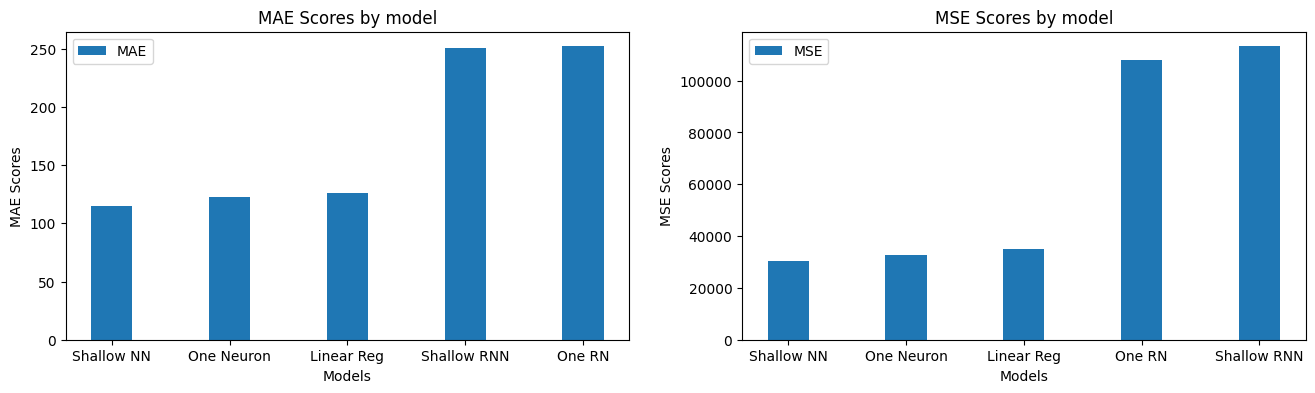

In [145]:
# Get the Elastic Net metrics
EN_data = pd.read_csv("model_output/elastic_net_results.csv")
LR_mae = EN_data.loc[EN_data['TARGET'] == 'flights_ontime', 'MAE'].values[0]
LR_mse = EN_data.loc[EN_data['TARGET'] == 'flights_ontime', 'MSE'].values[0]

models = ['Linear Reg', 'One Neuron', 'Shallow NN', 'One RN', 'Shallow RNN']
mae = [LR_mae, OneNeuron_val_mae, SDNN_val_mae,  OneRNN_val_mae, shallow_rnn_val_mae]
mse = [LR_mse, OneNeuron_val_mse, SDNN_val_mse, OneRNN_val_mse, shallow_rnn_val_mse]

# Sort by MAE
sorted_indices_mae = np.argsort(mae)
sorted_models_mae = [models[i] for i in sorted_indices_mae]
sorted_mae = [mae[i] for i in sorted_indices_mae]

# Sort by MSE
sorted_indices_mse = np.argsort(mse)
sorted_models_mse = [models[i] for i in sorted_indices_mse]
sorted_mse = [mse[i] for i in sorted_indices_mse]

x = np.arange(len(models))
bar_width = 0.35

fix, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

# MAE
axes[0].bar(x, sorted_mae, bar_width, label='MAE')
axes[0].set_xlabel('Models')
axes[0].set_ylabel('MAE Scores')
axes[0].set_title('MAE Scores by model')
axes[0].set_xticks(x)
axes[0].set_xticklabels(sorted_models_mae)
axes[0].legend()

# MSE
axes[1].bar(x, sorted_mse, bar_width, label='MSE')
axes[1].set_xlabel('Models')
axes[1].set_ylabel('MSE Scores')
axes[1].set_title('MSE Scores by model')
axes[1].set_xticks(x)
axes[1].set_xticklabels(sorted_models_mse)
axes[1].legend()

plt.tight_layout
plt.show()

## Next Steps
4. change filenames 
5. push to github
6. write up analysis
7. submit to coursera

## After submission
8. add XGBoost or Adaboost
9. update the raw data (selenium)